# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT \
    a. Analysis DMC values, timestep dependence \
    b. Comparison with DFT and CCSD(T) (writes *results_mol_dft.pkl*, which also includes CCSD(T) results, and in *delta_mol_ref.pkl* the delta energy with respect to the refence molecule )

3. Analyze dimers binding energies \
    a. Do extrapolations w/ w/o Jopt on molecules \
    b. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper

---

## Specific tasks here:

Copy data into \
    **data[mol][method][mol_id]**, \
where method is either the DFT functional or the DMC timestep (with err_{timestep} reporting the error). 
For DMC, consider only use **DMCdla5 Jopt**, and **mol_info[mol]['test']** is True. 
Notice that **data[mol]** can be converted in a **pd.DataFrame** with mol_id as index and method as columns.  

Comparison with **HF**, **DFT** (LDA, PBE, B3LYP) and **CCSD(T) cc-pV(D,T)Z** (orca)

Write in a file the delta energy for each structure (mol_id) of each molecule \
    **delta_mol_ref[mol][mol_id] = E[mol_id] - E[ref_mol_id]** \
where E is the energy at the B3LYP level, 
such that in a molecule where only one DMC evaluation was performed, in the **ref_mol_id** structure,
we can estimate \
    **Edmc[mol][mol_id] ~ Edmc[mol][ref_mol_id] + delta_mol_ref[mol][mol_id]**



In [1]:
import os
import re
import math
import pickle 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

# Read mol_info
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
df_mol_info

# Read results monomer
import pickle
with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
    results_mol = pickle.load( f )


In [2]:

# results_mol[ mol_name ][ mol_id ][ dmc_type ][ dmc_Jas ][ tau ]
# clear from fields without dmc results

list_clean = []

for mol in results_mol:
    #print(mol)
    for mol_id in results_mol[mol]:
        #print(mol_id)
        #for dmc_type in results_mol[mol][mol_id]:
            #print(dmc_type)
        if len(results_mol[mol][mol_id].keys())==0:
            print(mol,mol_id)
            list_clean.append( [mol,mol_id] )

#print(list_clean)
for l in list_clean:
    print(l)
    del results_mol[l[0]][l[1]]

Benzene 24_2
Pyridine 25_2
['Benzene', '24_2']
['Pyridine', '25_2']


# Collect DFT results on molecules on "results_mol_dft"
fixing the issue with dimer "35_Neopentane-Pentane", where Neopentane and Pentane are inverted in the monomers

In [3]:
# read DFT results and save in
# results_mol_dft[mol][mol_id][func]
# Dropbox/WORK/2021_S66/Representative_molecules/AcNH2/ORCA_HF

import os.path as path

list_func = []
list_func.append('LDA')
list_func.append('PBE')
list_func.append('B3LYP')
list_func.append('HF')

results_mol_dft = {}
for mol in mol_names:
    results_mol_dft[mol] = {}
    moldir = f'../Representative_molecules/{mol}'
    # extract mol_id names
    l = os.listdir( moldir )
    lxyz = [ s for s in l if s.endswith('.xyz') ]
    mol_ids = [ s[:4] for s in lxyz ]
    mol_ids.sort()
    print(mol,mol_ids)

    # make results_mol_dft[mol][mol_id] dictionary
    for mol_id in mol_ids:
        results_mol_dft[mol][mol_id] = {}
    
    # read results and copy energy for each functional
    for func in list_func:
        # see if ORCA_$func_scratch exists, otherwise use ORCA_$func
        outdir = moldir + f'/ORCA_{func}'
        outdir_scra = outdir+'_scratch'
        if path.exists(outdir_scra):
            #print(f'Dir exists {outdir_scra}')
            outdir = outdir_scra
        elif path.exists(outdir):
            #print(f'Dir scratch does not exist, but {outdir} {path.exists(outdir)}')
            pass
        else:
            print(f'Directory with outputs for {mol} not found!')
        for mol_id in mol_ids:
            outfile = f'{outdir}/{mol_id}_property.txt'
            if path.exists(outfile):
                try:
                    ene = 0.
                    for line in open(outfile,'r'):
                        if re.search('SCF Energy:',line):
                            ene = float( line.split()[-1] )
                    results_mol_dft[mol][mol_id][func] = ene * conv2au['kcal/mol']
                except Exception as e:
                    print(f'Exception reading {outfile}: {e}')

# copy on file
#import pickle
#with open( dir_analysis+'results_mol_dft.pkl', 'wb' ) as f:
#    pickle.dump( results_mol, f, pickle.HIGHEST_PROTOCOL )


AcNH2 ['21_1', '21_2', '23_1', '53_2', '62_2']
AcOH ['20_1', '20_2', '22_1', '52_2', '60_2', '61_2', '63_2']
Benzene ['24_1', '24_2', '27_1', '28_1', '30_1', '39_1', '40_1', '47_1', '47_2', '49_1', '50_1', '52_1', '53_1', '54_1', '55_1', '56_1', '57_1', '63_1']
Cyclopentane ['37_1', '38_1', '38_2', '39_2', '42_2']
Ethene ['30_2', '31_2', '33_2', '44_1', '64_2']
Ethyne ['32_2', '45_1', '50_2', '51_1', '51_2', '59_1', '60_1', '65_2']
MeNH2 ['03_2', '06_2', '09_1', '10_1', '10_2', '11_1', '12_1', '14_2', '56_2', '66_1']
MeOH ['02_2', '05_1', '05_2', '06_1', '07_1', '08_1', '09_2', '13_2', '19_1', '55_2']
Neopentane ['35_2', '36_1', '36_2', '37_2', '40_2', '43_2']
Pentane ['34_1', '34_2', '35_1', '41_2', '44_2', '45_2', '46_2', '61_1', '62_1']
Peptide ['04_2', '07_2', '11_2', '13_1', '14_1', '15_1', '15_2', '16_1', '46_1', '57_2', '64_1']
Pyridine ['18_2', '19_2', '25_1', '25_2', '27_2', '29_1', '33_1', '48_1', '48_2', '49_2', '58_1', '58_2', '65_1', '66_2']
Uracil ['17_1', '17_2', '22_2',

# Add to results_mol_dft the CCSD(T) results and save in "results_mol_dft.pkl"

In [4]:
# read CCSD(T) results and save in
# results_mol_ccsdt[mol][mol_id][func]
# Dropbox/WORK/2021_S66/DATA_CAM/Representative_molecules_CCSDt
# From Yasmine:
# Just a note: there is Water wand Water_small. 
# The first is with CBS@aug-cc-pV[T/Q]Z and the second is with CBS@cc-pV[D/T]Z. 
# This was to compare the effect of the basis set size on the results since 
# I didn't manage to use the larger basis set for other molecules (at least not with the memory on 1 node). 
# The differences for the two sets of results are very small: 0.00-0.01 kcal/mol in the water molecules 
# so I think the CBS with the smaller basis sets is fine

list_func.append('CCSD(T)')
list_func.append('CCSD(T) small')

for mol in mol_names:
    moldir = f'../DATA_CAM/Representative_molecules_CCSDt/{mol}'
    # read results and copy energy
    for func in ['CCSD(T)','CCSD(T) small']:
        if func.endswith('small'):
            outdir = moldir + '_small'
        else:
            # see if ORCA_$func_scratch exists, otherwise use ORCA_$func
            outdir = moldir 
        for mol_id in results_mol_dft[mol].keys():
            outfile = f'{outdir}/{mol_id}_property.txt'
            if path.exists(outfile):
                try:
                    #ene = 0.
                    for line in open(outfile,'r'):
                        #print(line)
                        if re.search('CBS Total Energy',line):
                            ene = float( line.split()[-1] )
                            #print( f'{mol} {mol_id} {ene} {outfile}' )
                    results_mol_dft[mol][mol_id][func] = ene * conv2au['kcal/mol']
                except Exception as e:
                    print(f'Exception reading {outfile}: {e}')

In [5]:
# fixing the issue with dimer "35_Neopentane-Pentane", 
# where Neopentane and Pentane are inverted in the monomers

results_mol_dft['Pentane']['35_2'] = results_mol_dft['Pentane'].pop('35_1')
results_mol_dft['Neopentane']['35_1'] = results_mol_dft['Neopentane'].pop('35_2')
results_mol_dft['Neopentane']

{'36_1': {'LDA': -122966.71055240193,
  'PBE': -123969.8307673841,
  'B3LYP': -124066.31128960637,
  'HF': -123252.95395006797,
  'CCSD(T)': -123928.35791246321,
  'CCSD(T) small': -123938.20515225992},
 '36_2': {'LDA': -122966.71073889581,
  'PBE': -123969.83089771647,
  'B3LYP': -124066.31139628188,
  'HF': -123252.95393839641,
  'CCSD(T)': -123928.35781846325,
  'CCSD(T) small': -123938.2051569662},
 '37_2': {'LDA': -122966.7398419202,
  'PBE': -123969.86085144668,
  'B3LYP': -124066.32958313858,
  'HF': -123252.94965556293,
  'CCSD(T)': -123928.35742319911,
  'CCSD(T) small': -123938.19394944886},
 '40_2': {'LDA': -122966.729549114,
  'PBE': -123969.82504825901,
  'B3LYP': -124066.28527094747,
  'HF': -123252.91320441567,
  'CCSD(T)': -123928.35141774442,
  'CCSD(T) small': -123938.19255545095},
 '43_2': {'LDA': -122966.74912055607,
  'PBE': -123969.85289106914,
  'B3LYP': -124066.29906766767,
  'HF': -123252.89466929481,
  'CCSD(T)': -123928.34546361945,
  'CCSD(T) small': -123938

In [6]:
# copy on file
import pickle
with open( dir_analysis+'results_mol_dft.pkl', 'wb' ) as f:
    pickle.dump( results_mol, f, pickle.HIGHEST_PROTOCOL )


#results_mol_dft

# Copy results_mol_dft into a dataframe df_results_mol_dft

In [7]:
# Write csv file with results dft for the mols

l = []
for mol in results_mol_dft:
    for mol_id in results_mol_dft[mol]:
        for func in results_mol_dft[mol][mol_id]:
            ene = float(results_mol_dft[mol][mol_id][func])
            #print( f'{mol} {mol_id} {func} {ene}' )
            data = {}
            data['ene']      = ene
            data['mol']      = mol
            data['mol_id']   = mol_id
            data['func']     = func
            l.append(data)

df_results_mol_dft = pd.DataFrame(l)
cols = list(df_results_mol_dft.columns)
cols = cols[::-1]
print(cols)
df_results_mol_dft = df_results_mol_dft[cols]
#df_results_mol_dft['xxx'] = df_results_mol_dft['xxx'].to_numpy().astype(np.float64)

#df_results_mol_dft.to_csv('results_mol_dft.csv')

df_results_mol_dft

['func', 'mol_id', 'mol', 'ene']


,func,mol_id,mol,ene
0,LDA,21_1,AcNH2,-130276.483761
1,PBE,21_1,AcNH2,-131193.473529
2,B3LYP,21_1,AcNH2,-131277.703356
3,HF,21_1,AcNH2,-130568.580486
4,CCSD(T),21_1,AcNH2,-131143.690104
...,...,...,...,...
787,PBE,59_2,Water,-47932.963606
788,B3LYP,59_2,Water,-47963.641473
789,HF,59_2,Water,-47732.010424
790,CCSD(T),59_2,Water,-47926.369011


# Add the delta energy (Ene-Eref) in the dataframe df_results_mol_dft for each method and save in csv file results_mol_dft.csv

In [8]:
# Add delta energy in results_mol_dft.csv
df_results_mol_dft['ref'] = ''
df_results_mol_dft['ene-ref'] = np.NaN
for i,row in df_results_mol_dft.iterrows():
    #print(i,list(row))
    func = row['func']
    mol = row['mol']
    ref = mol_info[mol]['ref']
    ene = row['ene']
    x = df_results_mol_dft.loc[(df_results_mol_dft.func==func) & 
                                  (df_results_mol_dft.mol==mol) &
                                  (df_results_mol_dft.mol_id==ref), 'ene']
    if len(x) == 1:
        Eref = float( x )
        delta = ene - Eref
    else:
        delta = np.NaN
    #print(i,func,mol,ene,ref,Eref,delta)
    df_results_mol_dft.loc[i,'ref'] = ref
    df_results_mol_dft.loc[i,'ene-ref'] = delta

df_results_mol_dft.to_csv('results_mol_dft.csv')

df_results_mol_dft

,func,mol_id,mol,ene,ref,ene-ref
0,LDA,21_1,AcNH2,-130276.483761,21_1,0.000000
1,PBE,21_1,AcNH2,-131193.473529,21_1,0.000000
2,B3LYP,21_1,AcNH2,-131277.703356,21_1,0.000000
3,HF,21_1,AcNH2,-130568.580486,21_1,0.000000
4,CCSD(T),21_1,AcNH2,-131143.690104,21_1,0.000000
...,...,...,...,...,...,...
787,PBE,59_2,Water,-47932.963606,01_2,0.005959
788,B3LYP,59_2,Water,-47963.641473,01_2,0.000226
789,HF,59_2,Water,-47732.010424,01_2,-0.019685
790,CCSD(T),59_2,Water,-47926.369011,01_2,-0.001349


# Compute delta_mol_ref (old approach)

In [9]:
# Put into data the molecular informations of DMCdla5,Jopt in the format
# data[mol][method][mol_id]
# where method if the DFT functional or the DMC timestep, and err_{timestep} the error

data = {}
dmc_Jas = 'Jopt'
#dmc_Jas = 'Jdimer'

for mol in results_mol_dft:
    #print(mol)
    data[mol] = {}
    for mol_id in results_mol_dft[mol]:
        #print(mol_id)
        for func in results_mol_dft[mol][mol_id]:
            ene = results_mol_dft[mol][mol_id][func]
            #print(mol,mol_id,func,ene)
            if func not in data[mol]:
                data[mol][func] = {}
            data[mol][func][ mol_id ] = ene
        # add data DMC
        if mol_id in results_mol[mol]:
            try: 
                dmc = results_mol[mol][mol_id]['DMCdla5'][dmc_Jas]
                for tau in dmc:
                    #print(mol,mol_id,tau,dmc[tau]['ene'])
                    if 'ene' in dmc[tau]:
                        if tau not in data[mol]:
                            data[mol][tau] = {}
                            data[mol]['err_'+tau] = {}
                        data[mol][tau][ mol_id ] = dmc[tau]['ene']
                        data[mol]['err_'+tau][ mol_id ] = dmc[tau]['err']
            except:
                pass

#data

In [10]:
# write the delta energy for each structure (mol_id) of each molecule 
# delta_mol_ref[mol][mol_id] = E[mol_id] - E[ref_mol_id]
# where E is the energy at the B3LYP level

delta_mol_ref = {}
refmethod = 'CCSD(T)'

for idx, mol in enumerate( mol_names ):

    ref_mol_id = mol_info[mol]['ref']
    print(f'MOLECULE: {mol}, ref {ref_mol_id}')

    #ref_mol_id = mol_info[mol]['ref']
    s = pd.Series( data[mol][refmethod] )
    ds = s-s[ref_mol_id]
    
    delta_mol_ref[mol] = dict( ds )

# Save into file
import pickle
with open( dir_analysis+'delta_mol_ref.pkl', 'wb' ) as f:
    pickle.dump( delta_mol_ref, f, pickle.HIGHEST_PROTOCOL )

#delta_mol_ref[mol][mol_id]
#delta_mol_ref

MOLECULE: AcNH2, ref 21_1
MOLECULE: AcOH, ref 20_1
MOLECULE: Benzene, ref 24_1
MOLECULE: Cyclopentane, ref 37_1
MOLECULE: Ethene, ref 30_2
MOLECULE: Ethyne, ref 32_2
MOLECULE: MeNH2, ref 56_2
MOLECULE: MeOH, ref 55_2
MOLECULE: Neopentane, ref 36_1
MOLECULE: Pentane, ref 34_1
MOLECULE: Peptide, ref 57_2
MOLECULE: Pyridine, ref 25_1
MOLECULE: Uracil, ref 26_1
MOLECULE: Water, ref 01_2


In [11]:
# write delta_mol_ref in DataFrame

l = []
for mol in delta_mol_ref:
    for mol_id in delta_mol_ref[mol]:
        delta = delta_mol_ref[mol][mol_id]
        x = {}
        x['mol'] = mol
        x['mol_id'] = mol_id
        x['ene-ref'] = delta
        l.append(x)
df_delta_mol_ref = pd.DataFrame(l)
df_delta_mol_ref.to_csv('delta_mol_ref.csv')
df_delta_mol_ref


,mol,mol_id,ene-ref
0,AcNH2,21_1,0.000000
1,AcNH2,21_2,-0.001602
2,AcNH2,23_1,0.056446
3,AcNH2,53_2,-0.646255
4,AcNH2,62_2,-0.704783
...,...,...,...
127,Water,12_2,0.115549
128,Water,16_2,-0.002680
129,Water,18_1,0.101107
130,Water,54_2,0.044070


# Check consistency 2 calculations of delta_mol_ref

In [12]:
# Check
s1 = df_results_mol_dft.loc[ df_results_mol_dft.func=='CCSD(T)', 'ene-ref' ].to_numpy()
s2 = df_delta_mol_ref['ene-ref'].to_numpy()
#print( s1 )
#print( s2 )
s1-s2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# PLOTS

MOLECULE: AcNH2
Doing AcNH2 ref=21_1, idx=0
MOLECULE: AcOH
Doing AcOH ref=20_1, idx=1
MOLECULE: Benzene
Doing Benzene ref=24_1, idx=2
MOLECULE: Cyclopentane
Doing Cyclopentane ref=37_1, idx=3
MOLECULE: Ethene
Doing Ethene ref=30_2, idx=4
MOLECULE: Ethyne
Doing Ethyne ref=32_2, idx=5
MOLECULE: MeNH2
Doing MeNH2 ref=56_2, idx=6
MOLECULE: MeOH
Doing MeOH ref=55_2, idx=7
MOLECULE: Neopentane
Doing Neopentane ref=36_1, idx=8
MOLECULE: Pentane
Doing Pentane ref=34_1, idx=9
MOLECULE: Peptide
Doing Peptide ref=57_2, idx=10
MOLECULE: Pyridine
Doing Pyridine ref=25_1, idx=11
MOLECULE: Uracil
Doing Uracil ref=26_1, idx=12
MOLECULE: Water
Doing Water ref=01_2, idx=13


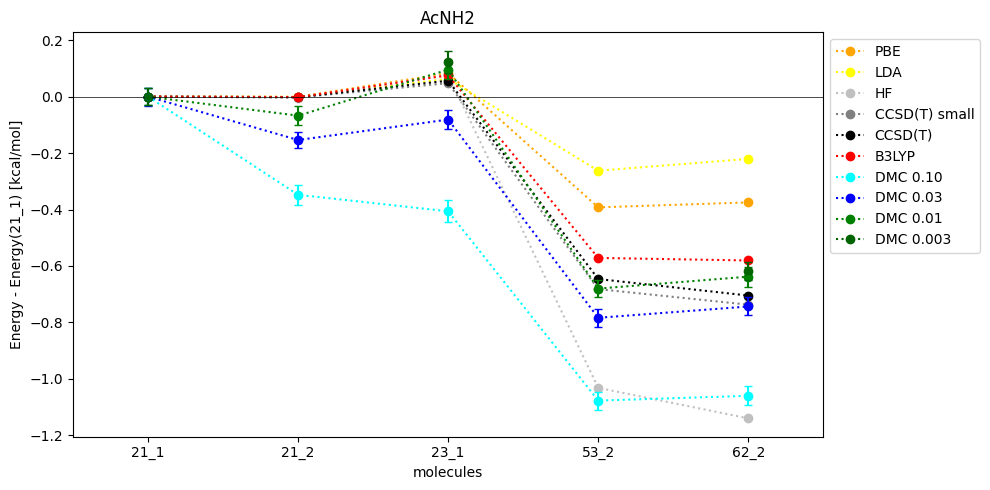

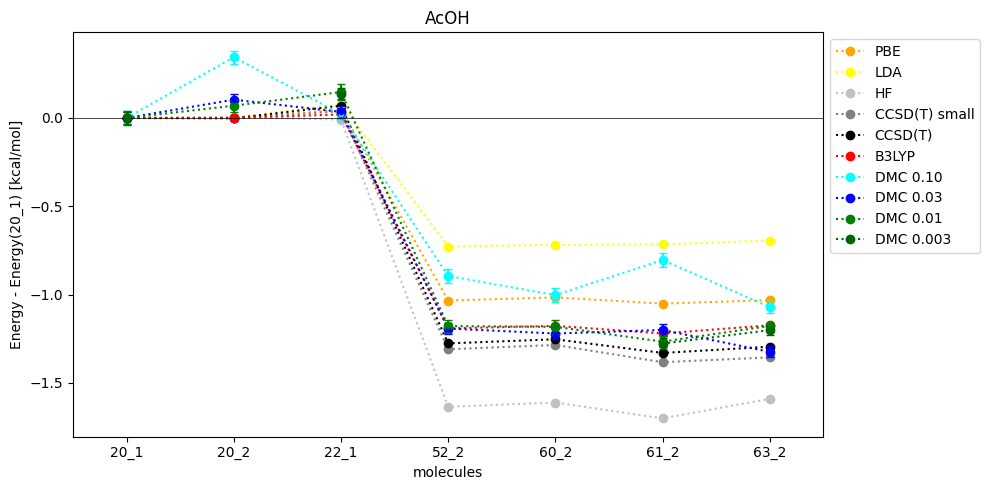

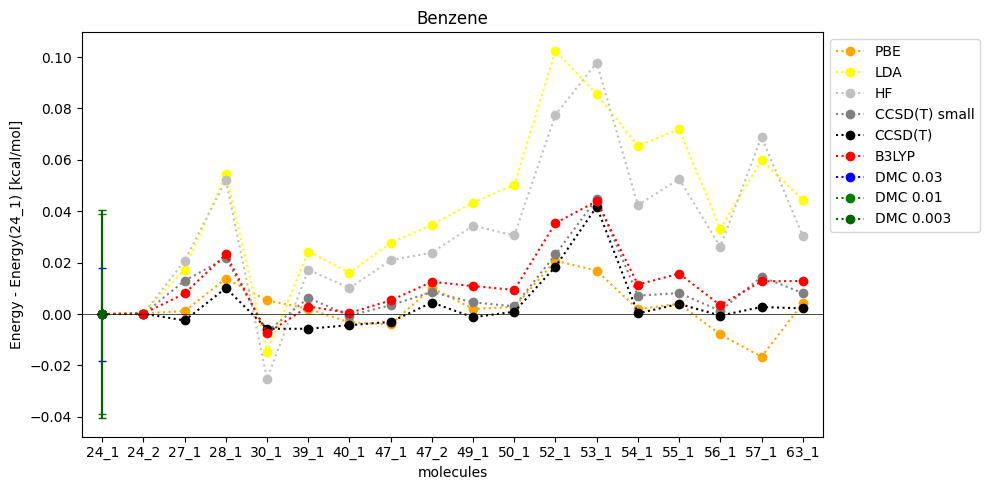

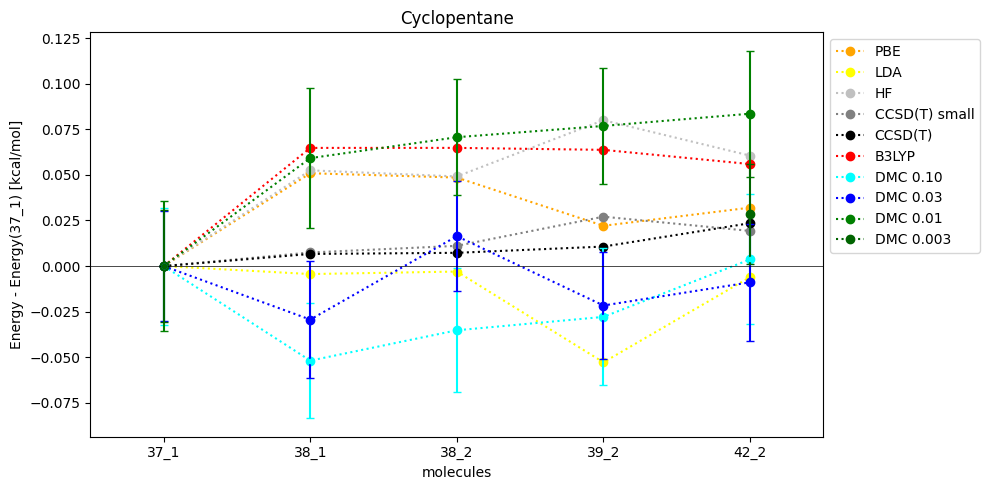

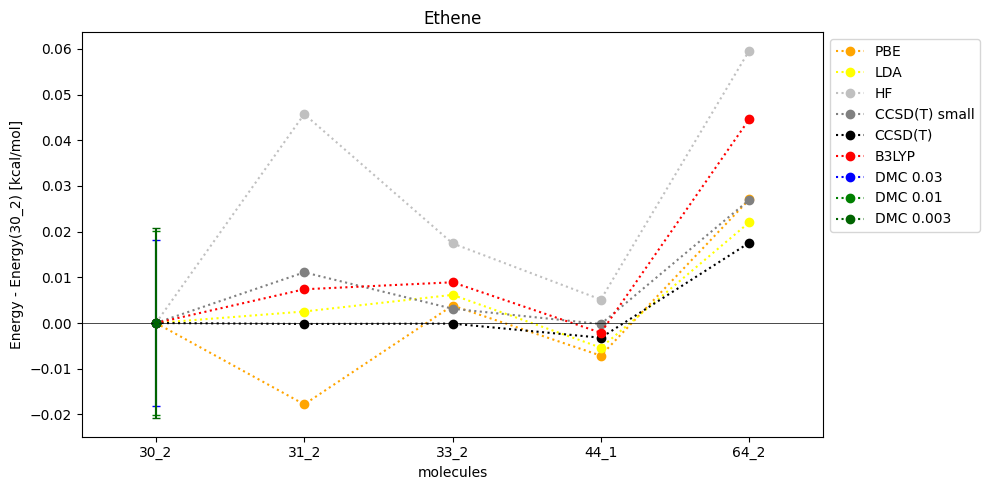

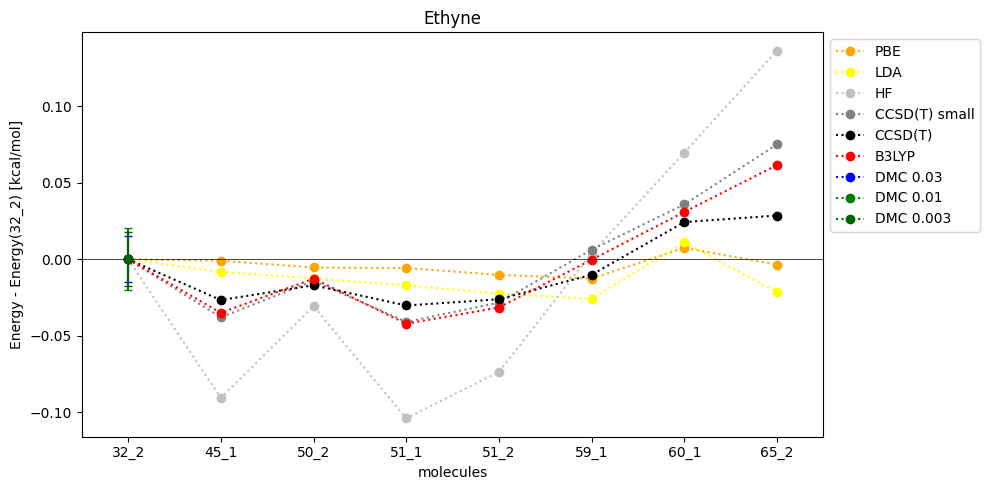

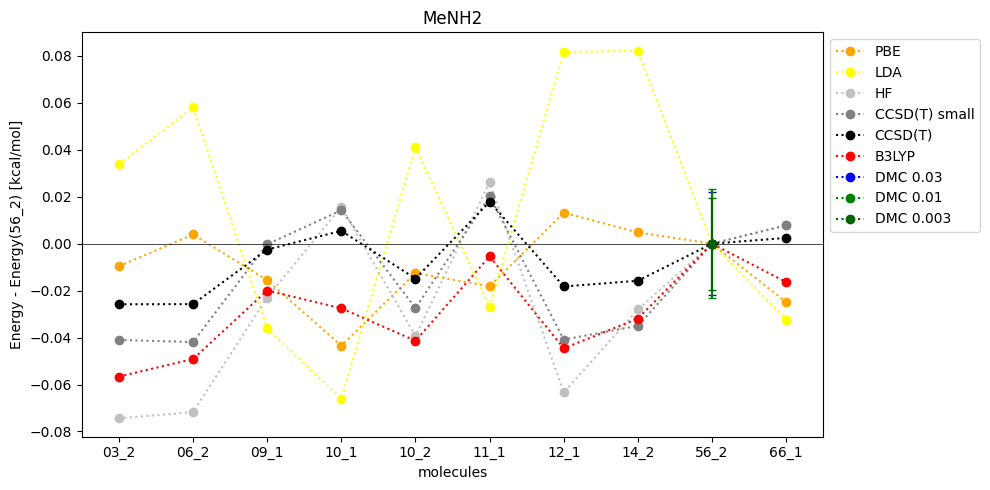

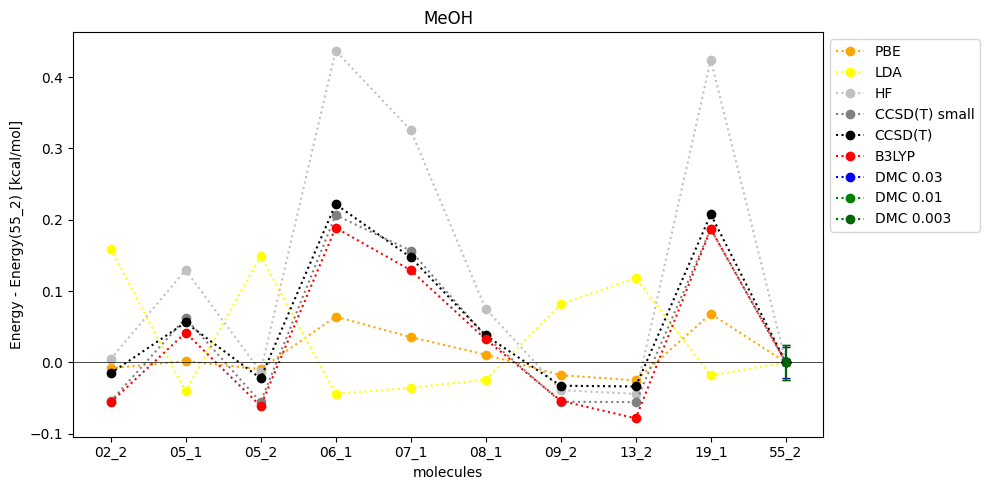

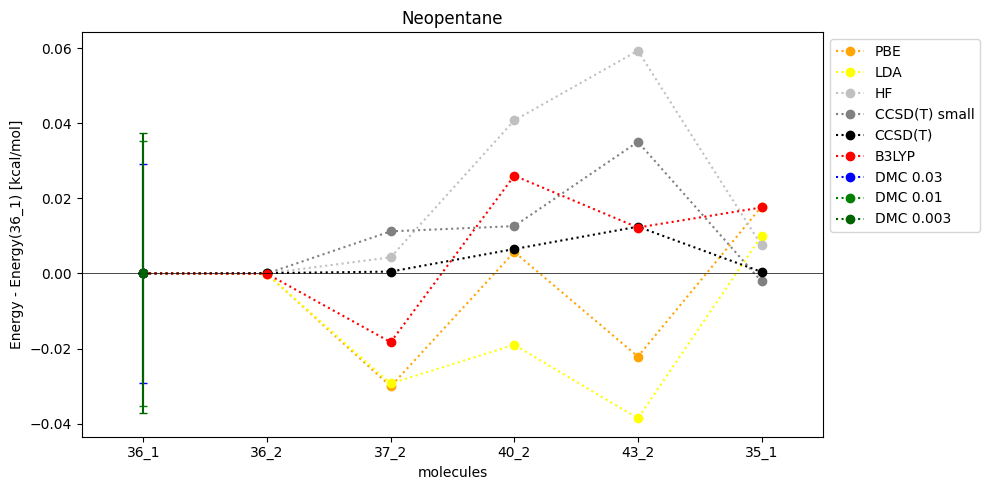

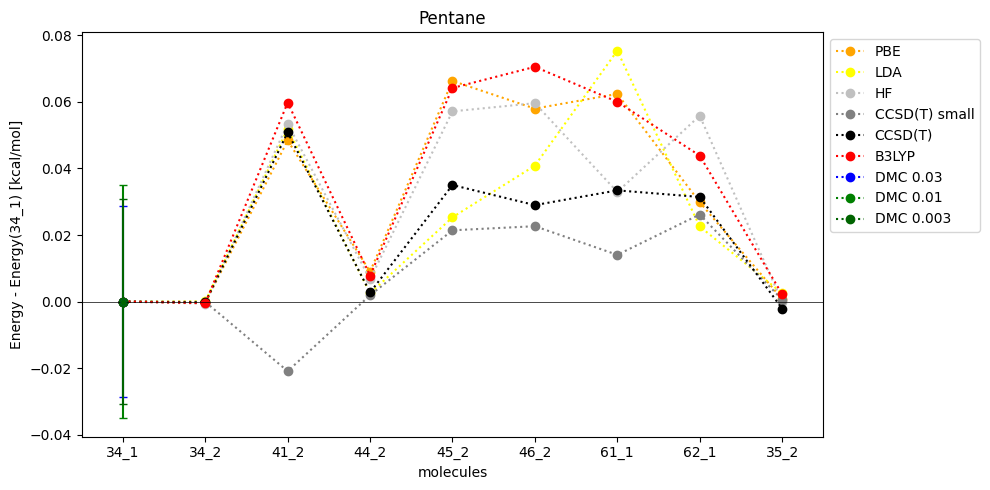

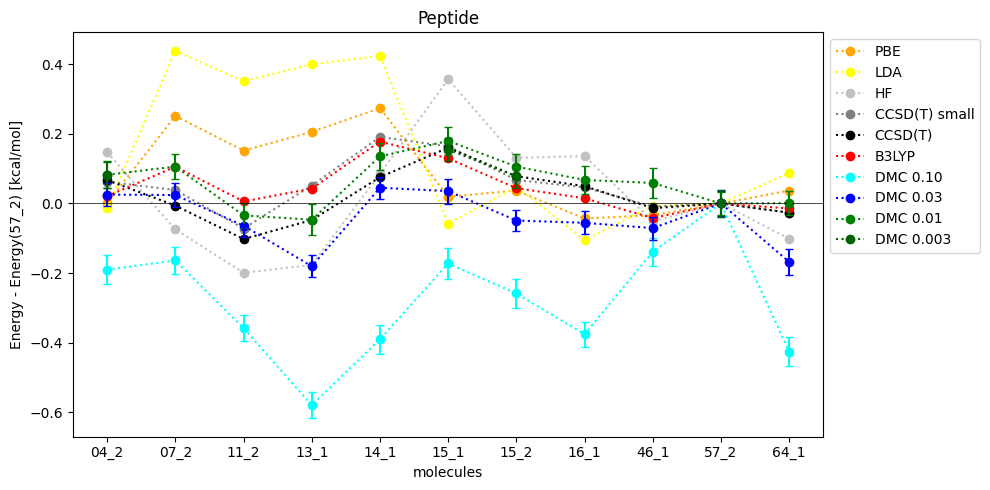

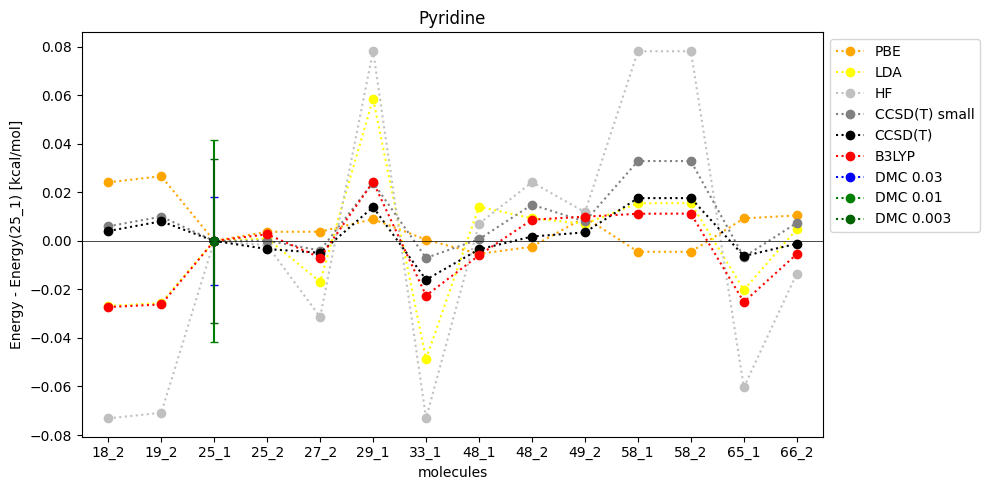

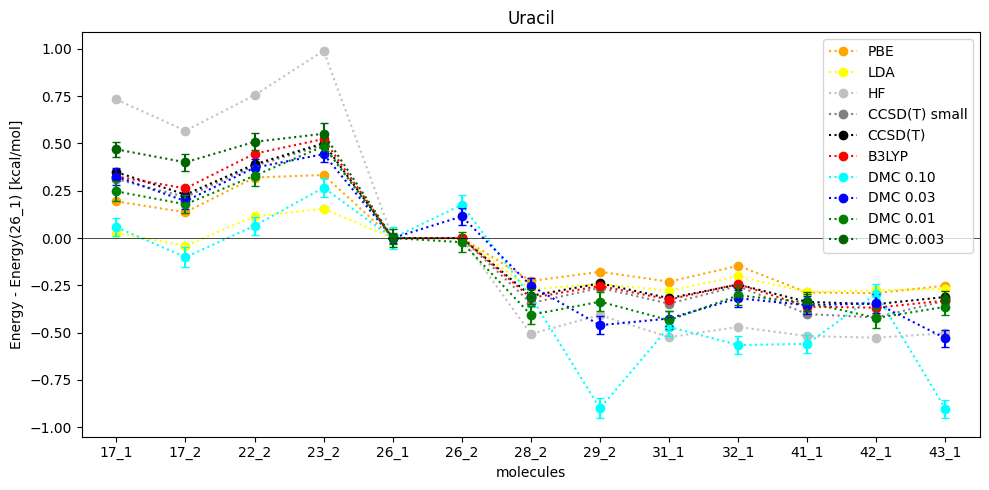

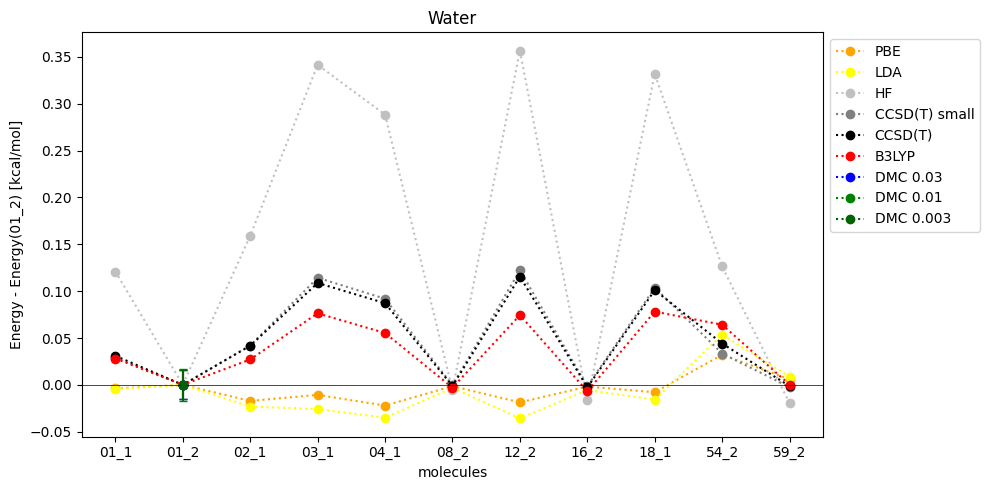

In [13]:
# Plot Effective timestep for representative molecules
verbose = False

for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')
    
    df = pd.DataFrame( data[mol] )
    Xlabels = df.index
    X = np.arange(len(Xlabels))

    ref_mol_id = mol_info[mol]['ref']
    print( f'Doing {mol} ref={ref_mol_id}, idx={idx}' )

    fig, ax = plt.subplots(figsize=(10, 5) )
    ax.set_title(f'{mol}')

    ax.set_xlim([-0.5,-0.5+len(Xlabels)])
    ax.set_xticks(ticks=X)
    ax.set_xticklabels(labels=Xlabels,rotation=0)

    ax.set_ylabel(f'Energy - Energy({ref_mol_id}) [kcal/mol]')
    ax.set_xlabel('molecules')

    methods = list( df.columns )
    methods.sort()
    for method in methods[::-1]:
        if verbose: 
            print(method)
            print(df[method])

        if not method.startswith('err_'):

            try:
                Yref = float( df.at[ref_mol_id,method] )
                Y = np.array( df[method], dtype=np.double )
                c = dft_color( method )
                if method.startswith('0.'):
                    label = 'DMC '+method
                else:
                    label = method
                if (len( Y[ ~np.isnan(Y) ] )>1) or (method in ['0.003','0.01','0.03','0,10']) :
                    #print(f'{label} X={X} Y={Y}')
                    ax.plot( X, Y-Yref, 'o:', label=label , color=c )
                    err_method = 'err_'+method
                    if err_method in df:
                        Yerr = np.array( df[err_method], dtype=np.double )
                        ax.errorbar( X, Y-Yref, Yerr, color=c, fmt='.', capsize=3 )
            except:
                print( f'Exception with {method}: {Yref} {Y}' )
                pass

    ax.hlines(0,-1,len(X),color='black', lw=0.5)#, label='Target', linestyles='dashdot',
    #plt.ylim([0.86,1.02])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend( bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG02b/DeltaE_{mol}.png',format='png',dpi=300)
    

MOLECULE: AcNH2
MOLECULE: AcOH
MOLECULE: Benzene
MOLECULE: Cyclopentane
MOLECULE: Ethene
MOLECULE: Ethyne
MOLECULE: MeNH2
MOLECULE: MeOH
MOLECULE: Neopentane
MOLECULE: Pentane
MOLECULE: Peptide
MOLECULE: Pyridine
MOLECULE: Uracil
MOLECULE: Water


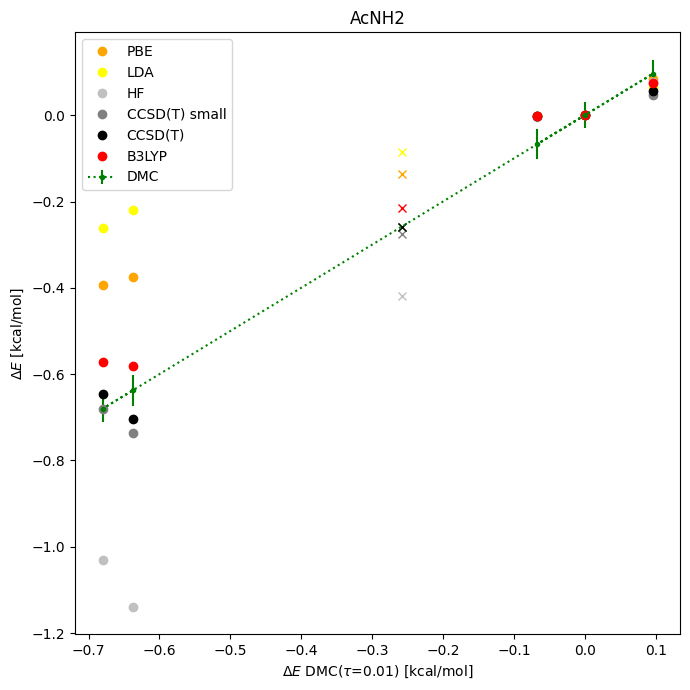

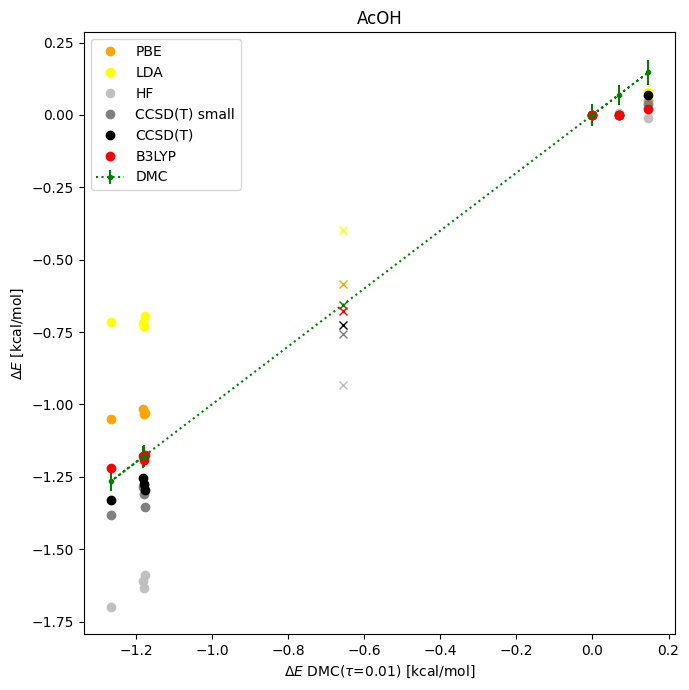

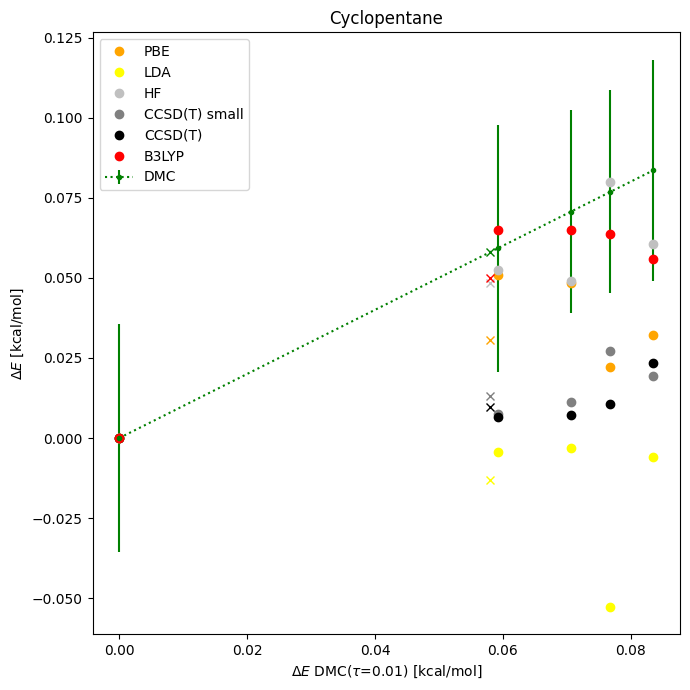

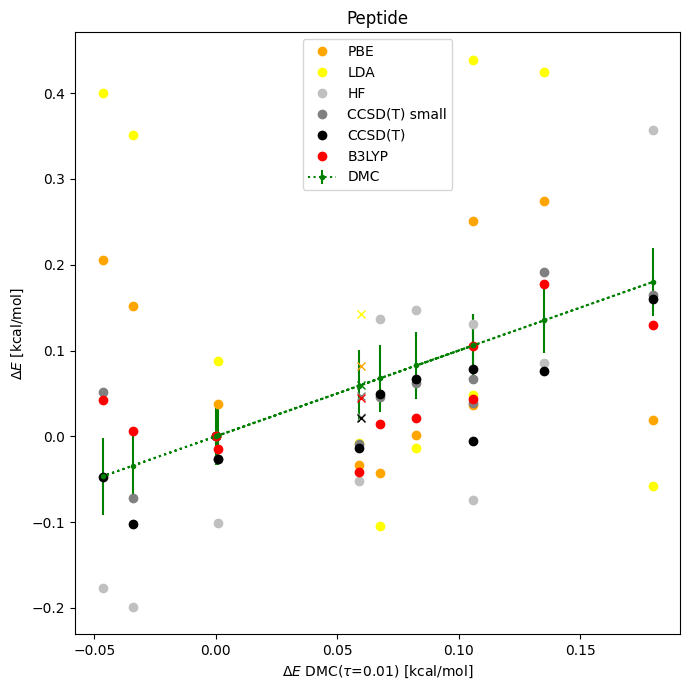

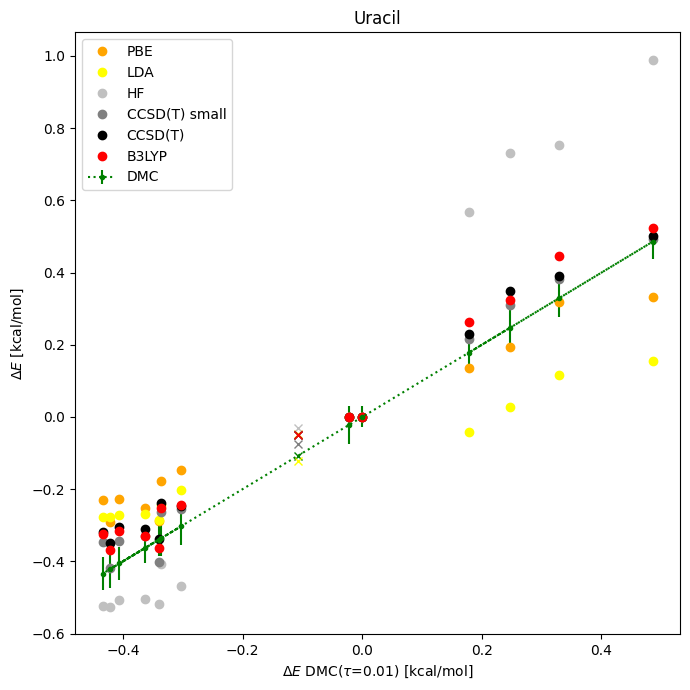

In [14]:
# Plot Effective timestep for representative molecules
verbose = False

for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')

    if mol_info[mol]['test']:
        fig, ax = plt.subplots(figsize=(7, 7) )
        ax.set_title( f'{mol}' )

        df = pd.DataFrame( data[mol] )
        ax.set_ylabel(r'$\Delta E$ [kcal/mol]')
        ax.set_xlabel(r'$\Delta E$ DMC($\tau$=0.01) [kcal/mol]')
        
        ref_mol_id = mol_info[mol]['ref']
        Xref = df.at[ref_mol_id,'0.01']
        X    = np.array( df['0.01'], dtype=np.double )
        Xerr = np.array( df['err_0.01'], dtype=np.double )
        Xave = X.mean()

        ax.errorbar( X-Xref, X-Xref, xerr=None, yerr=Xerr, fmt='.:', color='green', label='DMC' )
        ax.plot( Xave-Xref, Xave-Xref, 'x', color='green')

        methods = list( df.columns )
        methods.sort()
        for method in methods[::-1]:
            if verbose: 
                print(method)
                print(df[method])

            if not method.startswith('err_') and not method.startswith('0.'):
                Yref = df.at[ref_mol_id,method]
                Y = np.array( df[method], dtype=np.double )
                #Yerr = np.array( df['err_0.01'], dtype=np.double )
                Yave = Y.mean()
                c = dft_color( method )
                ax.plot( X-Xref, Y-Yref, 'o', label=method , color=c )
                ax.plot( Xave-Xref, Yave-Yref, 'x', color=c)

        ax.legend() # bbox_to_anchor=(1., 1.))

        fig.tight_layout()
        fig.savefig(f'FIG02b/ScatterDeltaE_{mol}.png',format='png',dpi=300)
        

MOLECULE: AcNH2
MOLECULE: AcOH
MOLECULE: Benzene
MOLECULE: Cyclopentane
MOLECULE: Ethene
MOLECULE: Ethyne
MOLECULE: MeNH2
MOLECULE: MeOH
MOLECULE: Neopentane
MOLECULE: Pentane
MOLECULE: Peptide
MOLECULE: Pyridine
MOLECULE: Uracil
MOLECULE: Water


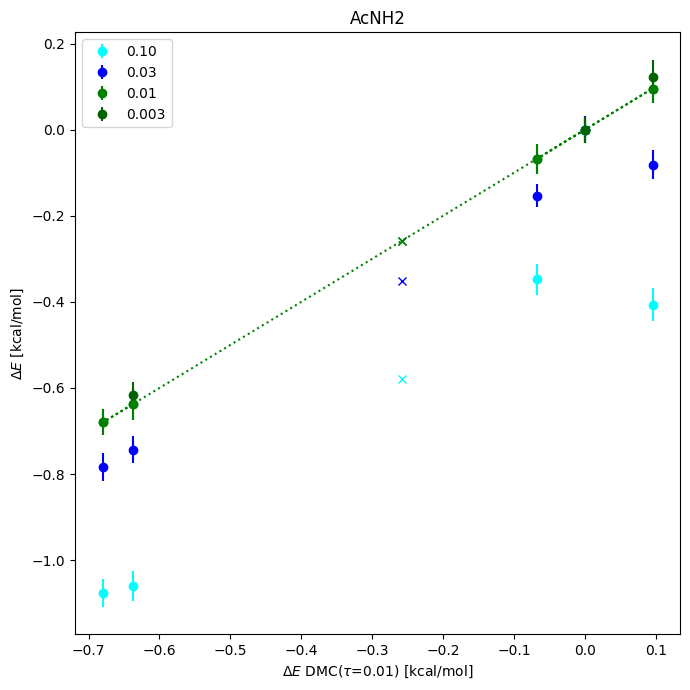

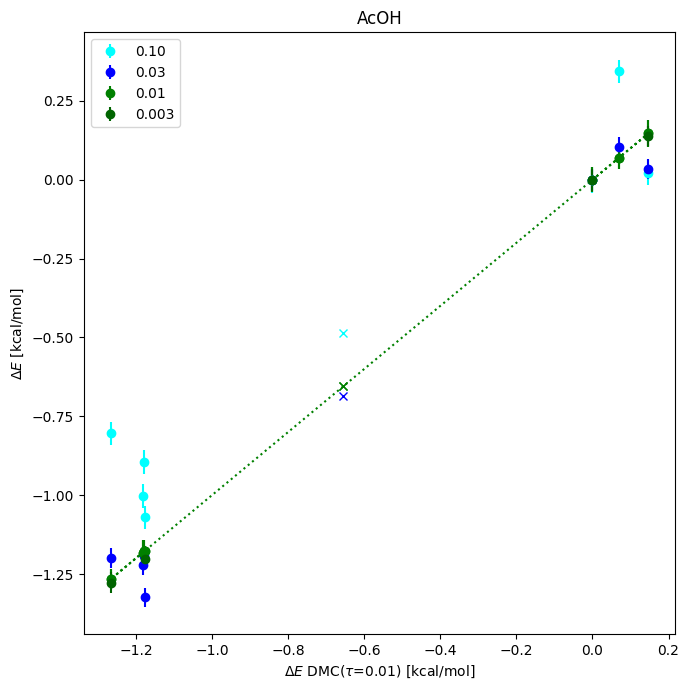

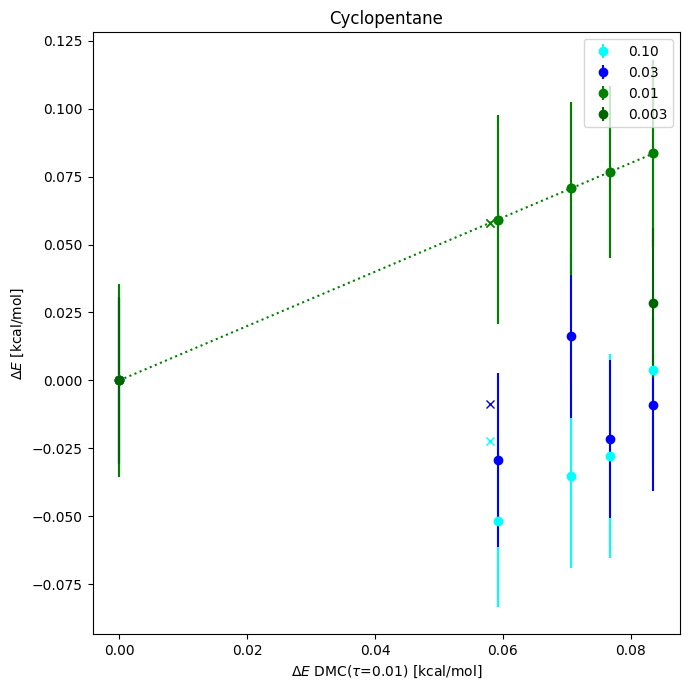

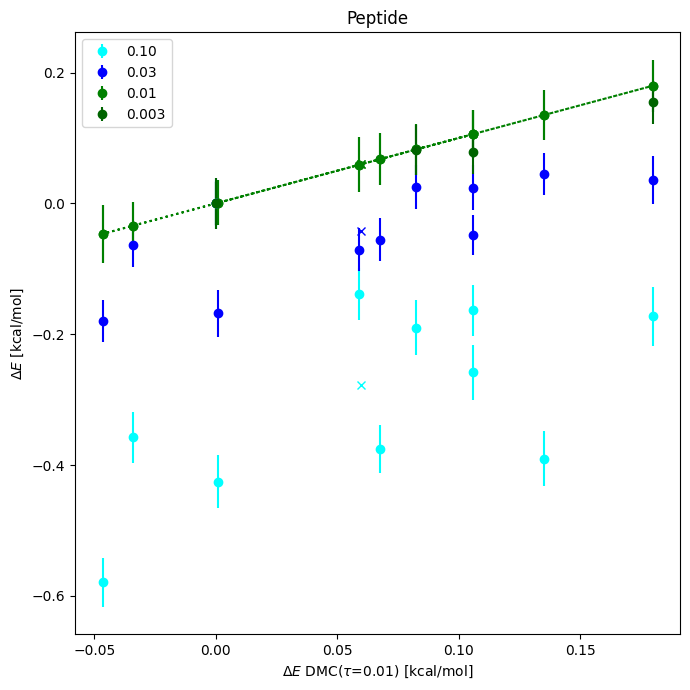

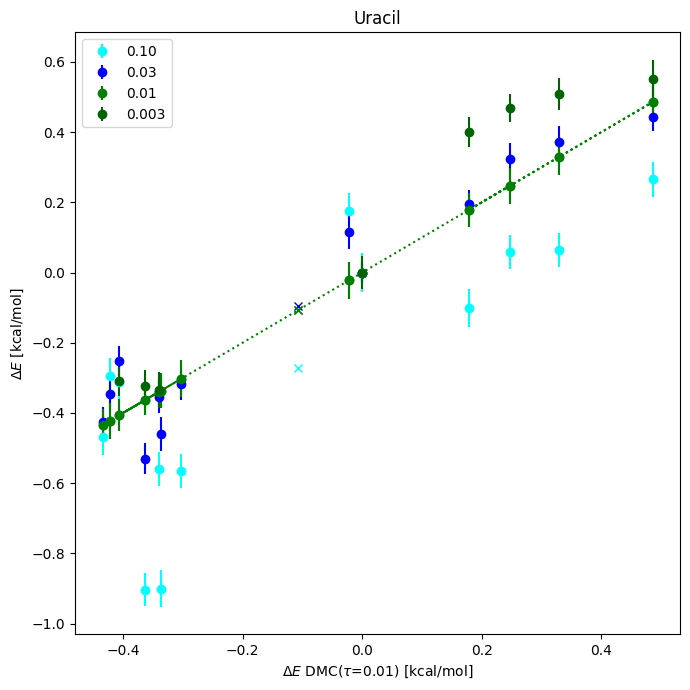

In [15]:
# Plot Effective timestep for representative molecules
verbose = False

for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')

    if mol_info[mol]['test']:
        fig, ax = plt.subplots(figsize=(7, 7) )
        ax.set_title( f'{mol}' )

        df = pd.DataFrame( data[mol] )
        ax.set_ylabel(r'$\Delta E$ [kcal/mol]')
        ax.set_xlabel(r'$\Delta E$ DMC($\tau$=0.01) [kcal/mol]')
        
        ref_mol_id = mol_info[mol]['ref']
        Xref = df.at[ref_mol_id,'0.01']
        X = np.array( df['0.01'], dtype=np.double )
        Xerr = np.array( df['err_0.01'], dtype=np.double )
        Xave = X.mean()

        ax.errorbar( X-Xref, X-Xref, xerr=None, yerr=Xerr, fmt='o:', color='green' )
        ax.plot( Xave-Xref, Xave-Xref, 'x', color='green')

        methods = list( df.columns )
        methods.sort()
        for method in methods[::-1]:
            if verbose: 
                print(method)
                print(df[method])

            #if not method.startswith('err_') and method.startswith('0.'):
            if method in ('0.10','0.03','0.01','0.003'):
                Yref = df.at[ref_mol_id,method]
                Y = np.array( df[method], dtype=np.double )
                Yerr = np.array( df['err_'+method], dtype=np.double )
                Yave = Y.mean()
                c = dft_color( method )
                ax.errorbar( X-Xref, Y-Yref, yerr=Yerr, fmt='o', label=method , color=c )
                ax.plot( Xave-Xref, Yave-Yref, 'x', color=c)

        ax.legend() # bbox_to_anchor=(1., 1.))

        fig.tight_layout()
        fig.savefig(f'FIG02b/ScatterDeltaDMCtau_{mol}.png',format='png',dpi=300)
        

ref_method = CCSD(T)

MOLECULE: AcNH2
ref_mol_id = 21_1

MOLECULE: AcOH
ref_mol_id = 20_1

MOLECULE: Benzene
No test data!

MOLECULE: Cyclopentane
ref_mol_id = 37_1

MOLECULE: Ethene
No test data!

MOLECULE: Ethyne
No test data!

MOLECULE: MeNH2
No test data!

MOLECULE: MeOH
No test data!

MOLECULE: Neopentane
No test data!

MOLECULE: Pentane
No test data!

MOLECULE: Peptide
ref_mol_id = 57_2

MOLECULE: Pyridine
No test data!

MOLECULE: Uracil
ref_mol_id = 26_1

MOLECULE: Water
No test data!



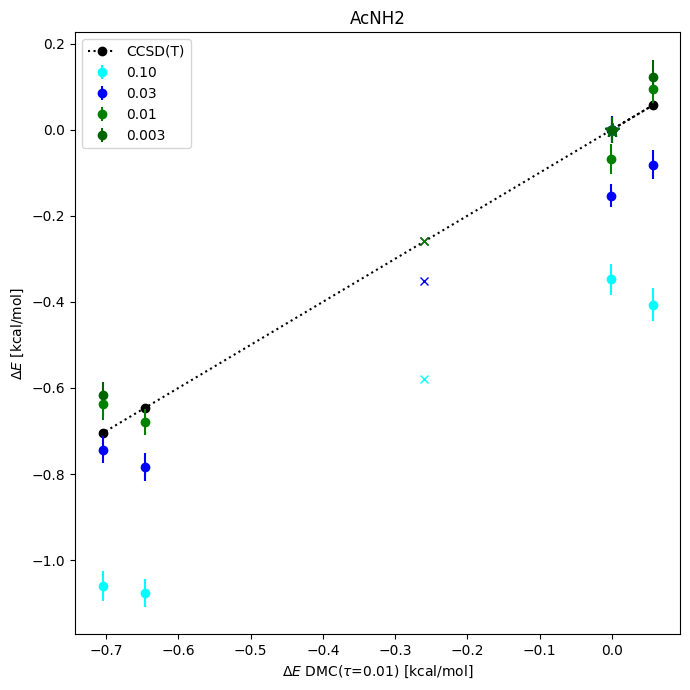

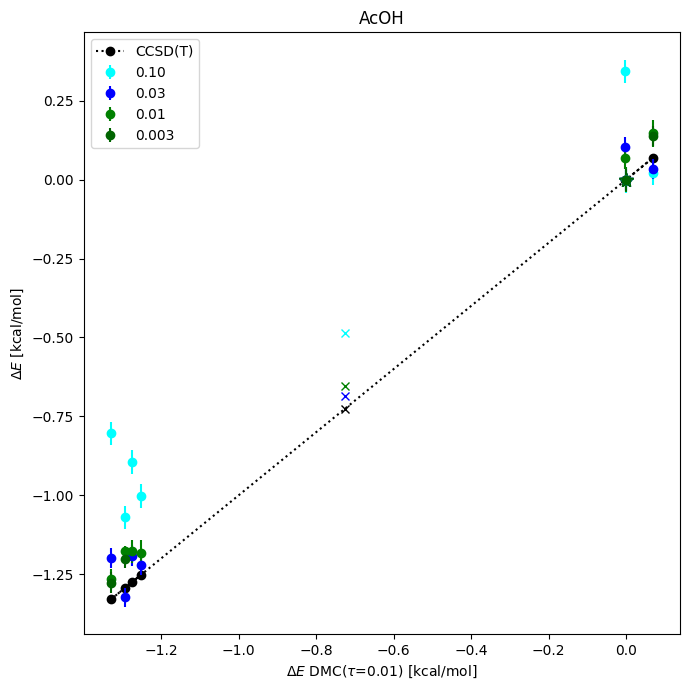

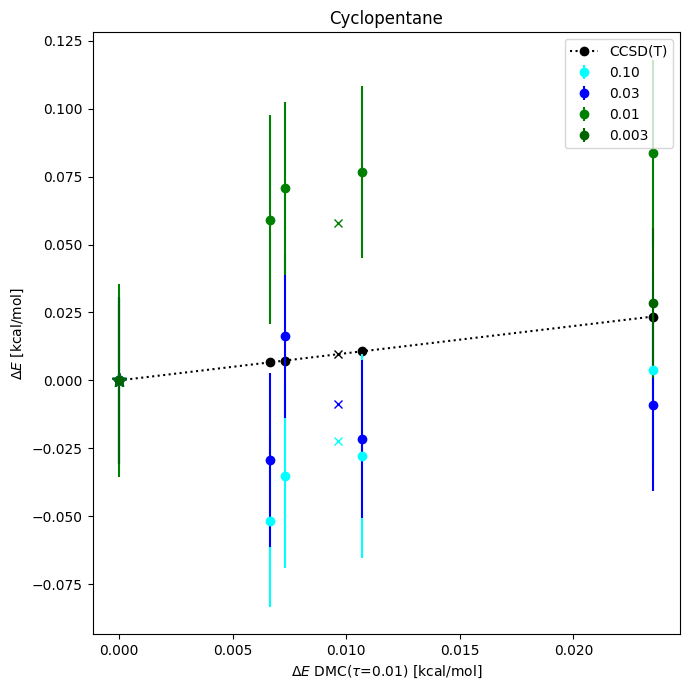

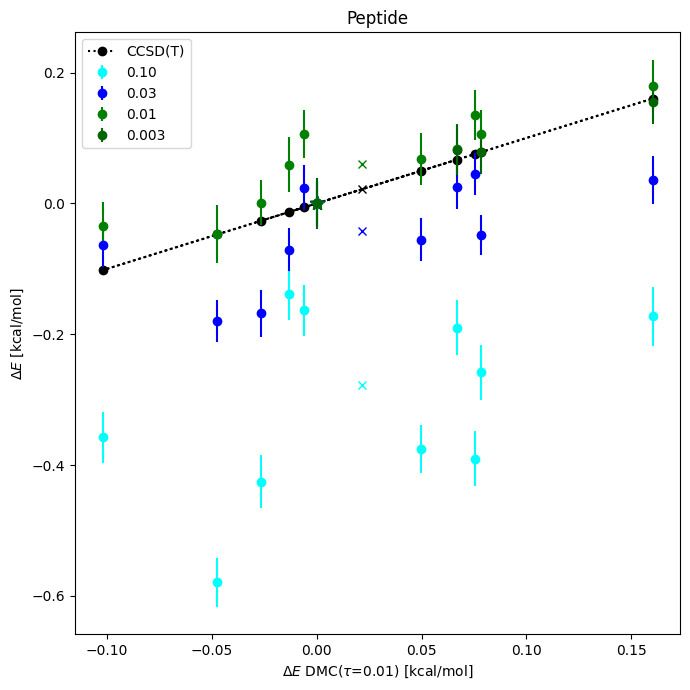

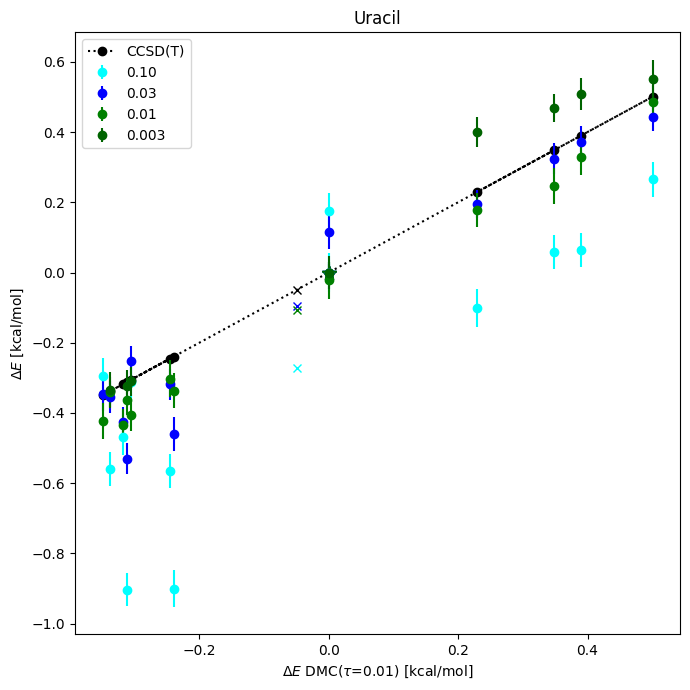

In [16]:
# Plot Effective timestep for representative molecules
verbose = False

ref_method = 'CCSD(T)'
print(f'ref_method = {ref_method}\n')

for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')

    if mol_info[mol]['test']:
        fig, ax = plt.subplots(figsize=(7, 7) )
        ax.set_title( f'{mol}' )

        df = pd.DataFrame( data[mol] )
        ax.set_ylabel(r'$\Delta E$ [kcal/mol]')
        ax.set_xlabel(r'$\Delta E$ DMC($\tau$=0.01) [kcal/mol]')
        
        ref_mol_id = mol_info[mol]['ref']
        print(f'ref_mol_id = {ref_mol_id}\n')

        Xref = df.at[ref_mol_id,ref_method]
        X    = np.array( df[ref_method], dtype=np.double )
        Xave = X.mean()

        ax.plot( X-Xref, X-Xref, 'o:', color=dft_color(ref_method), label=ref_method )
        ax.plot( Xref-Xref, Xref-Xref, '*', markersize=10, color=dft_color(ref_method) )
        ax.plot( Xave-Xref, Xave-Xref, 'x', color=dft_color(ref_method))

        methods = list( df.columns )
        methods.sort()
        for method in methods[::-1]:
            if verbose: 
                print(method)
                print(df[method])

            #if not method.startswith('err_') and method.startswith('0.'):
            #if method in ('0.10'):
            if method in ('0.10','0.03','0.01','0.003'):
                Yref = df.at[ref_mol_id,method]
                Y = np.array( df[method], dtype=np.double )
                Yerr = np.array( df['err_'+method], dtype=np.double )
                Yave = Y.mean()
                c = dft_color( method )
                ax.errorbar( X-Xref, Y-Yref, yerr=Yerr, fmt='o', label=method , color=c )
                ax.plot( Xref-Xref, Yref-Yref, '*', markersize=10, color=c )
                ax.plot( Xave-Xref, Yave-Yref, 'x', color=c)

        ax.legend() # bbox_to_anchor=(1., 1.))

        fig.tight_layout()
        fig.savefig(f'FIG02b/ScatterCCSDT_DeltaDMCtau_{mol}.png',format='png',dpi=300)
    else:
        print('No test data!\n')
        

MOLECULE: AcNH2
MOLECULE: AcOH
MOLECULE: Benzene
MOLECULE: Cyclopentane
MOLECULE: Ethene
MOLECULE: Ethyne
MOLECULE: MeNH2
MOLECULE: MeOH
MOLECULE: Neopentane
MOLECULE: Pentane
MOLECULE: Peptide
MOLECULE: Pyridine
MOLECULE: Uracil
MOLECULE: Water


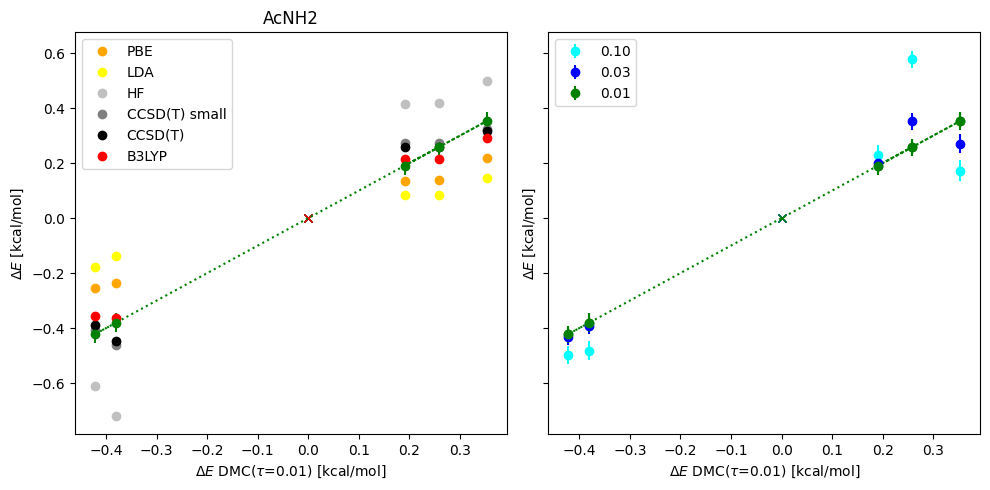

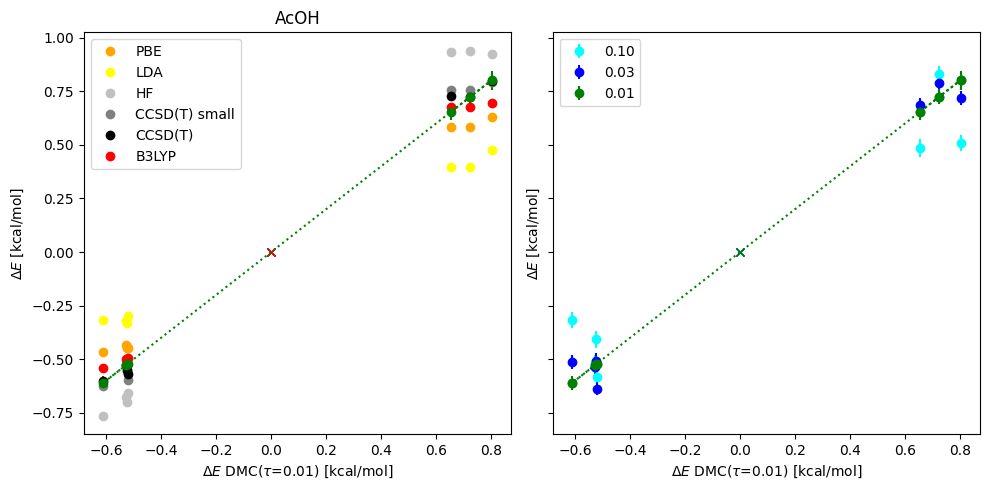

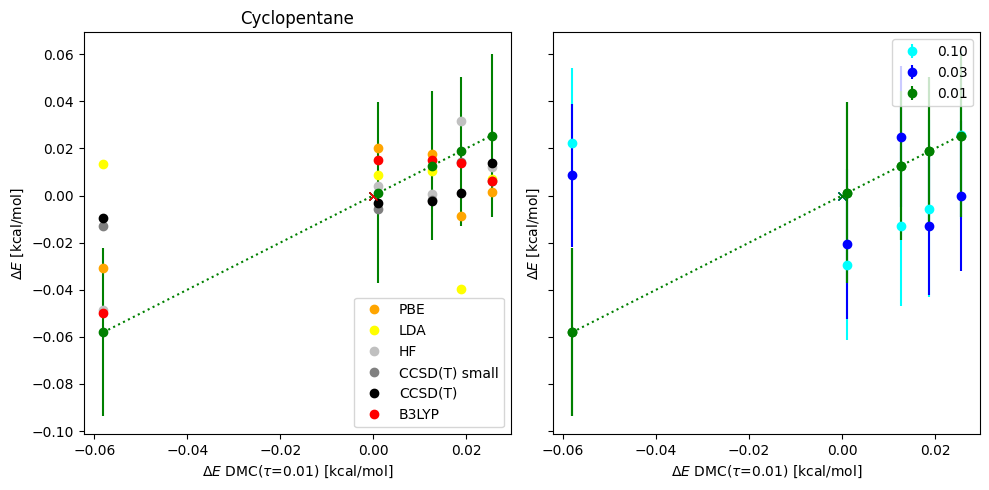

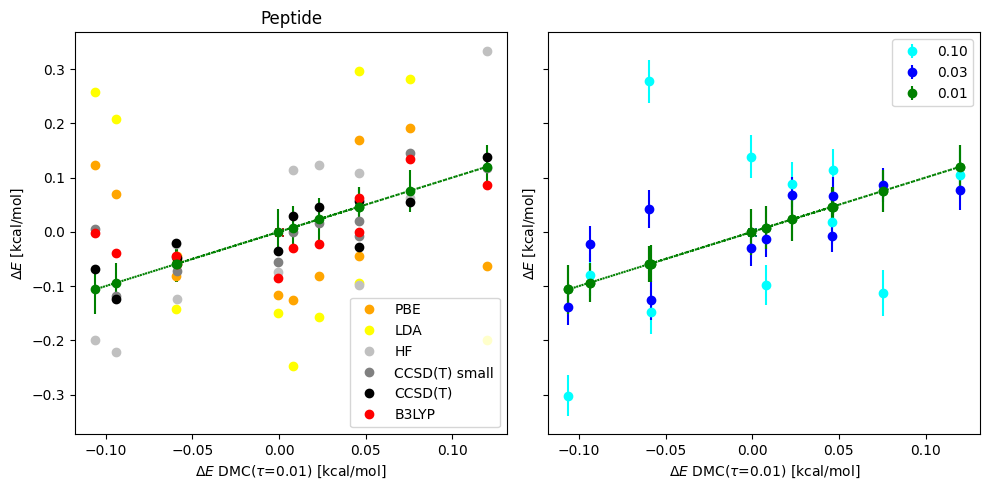

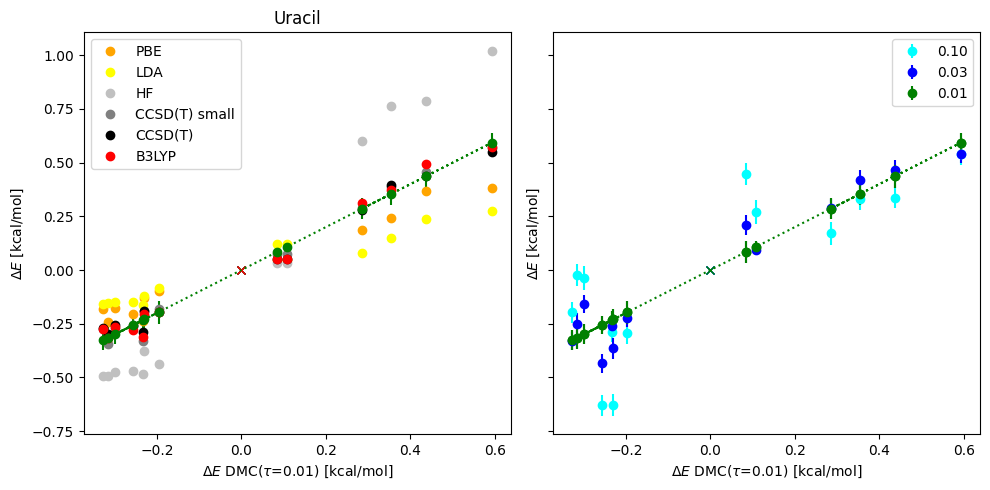

In [17]:
# Plot Effective timestep for representative molecules
verbose = False

for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')

    if mol_info[mol]['test']:
        fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 5) )
        ax1.set_title( f'{mol}' )

        for ax in [ax1,ax2]:
            df = pd.DataFrame( data[mol] )
            ax.set_ylabel(r'$\Delta E$ [kcal/mol]')
            ax.set_xlabel(r'$\Delta E$ DMC($\tau$=0.01) [kcal/mol]')

            X = np.array( df['0.01'], dtype=np.double )
            Xerr = np.array( df['err_0.01'], dtype=np.double )
            Xave = X.mean()

            ref_mol_id = mol_info[mol]['ref']
            #Xref = df.at[ref_mol_id,'0.01']
            Xref = Xave
            
            ax.errorbar( X-Xref, X-Xref, xerr=None, yerr=Xerr, fmt='o:', color='green' )
            ax.plot( Xave-Xref, Xave-Xref, 'x', color='green')

        methods = list( df.columns )
        methods.sort()
        for method in methods[::-1]:
            if verbose: 
                print(method)
                print(df[method])

            if not method.startswith('err_') and not method.startswith('0.'):
                Y = np.array( df[method], dtype=np.double )
                Yave = Y.mean()
                #Yref = df.at[ref_mol_id,method]
                Yref = Yave
                c = dft_color( method )
                ax1.plot( X-Xref, Y-Yref, 'o', label=method , color=c )
                ax1.plot( Xave-Xref, Yave-Yref, 'x', color=c)

            if not method.startswith('err_') and method.startswith('0.'):
                Y = np.array( df[method], dtype=np.double )
                if np.all( ~np.isnan(Y) ):
                    Yerr = np.array( df['err_'+method], dtype=np.double )
                    Yave = Y.mean()
                    #Yref = df.at[ref_mol_id,method]
                    Yref = Yave
                    c = dft_color( method )
                    ax2.errorbar( X-Xref, Y-Yref, yerr=Yerr, fmt='o', label=method , color=c )
                    ax2.plot( Xave-Xref, Yave-Yref, 'x', color=c)

        ax1.legend() # bbox_to_anchor=(1., 1.))
        ax2.legend() # bbox_to_anchor=(1., 1.))

        fig.tight_layout()
        fig.savefig(f'FIG02b/ScatterDeltaAll_{mol}.png',format='png',dpi=300)
        

# TEST

In [18]:
#mols = list(df_results_mol_dft.mol)
mols = df_results_mol_dft.mol
refs = [ mol_info[mol]['ref'] for mol in mols ]
df_results_mol_dft['ref'] = refs
df_results_mol_dft

,func,mol_id,mol,ene,ref,ene-ref
0,LDA,21_1,AcNH2,-130276.483761,21_1,0.000000
1,PBE,21_1,AcNH2,-131193.473529,21_1,0.000000
2,B3LYP,21_1,AcNH2,-131277.703356,21_1,0.000000
3,HF,21_1,AcNH2,-130568.580486,21_1,0.000000
4,CCSD(T),21_1,AcNH2,-131143.690104,21_1,0.000000
...,...,...,...,...,...,...
787,PBE,59_2,Water,-47932.963606,01_2,0.005959
788,B3LYP,59_2,Water,-47963.641473,01_2,0.000226
789,HF,59_2,Water,-47732.010424,01_2,-0.019685
790,CCSD(T),59_2,Water,-47926.369011,01_2,-0.001349


In [19]:
df = pd.DataFrame(results_mol['AcNH2']['21_1']['DMCdla5']['Jopt']).transpose()
newindex = [float(tau) for tau in df.index]
df.index = newindex
df.sort_index(ascending=False, inplace=True)
df
#df[['ene','err']]
df[ df.index < 0.05 ]
#df[ df.index < 0.05 ]['ene']

,ene,err,units,TotTimeSim[au],Pop,Pop-err,Var[au],tau_eff[au],corr-time[au],machine,N_MPI,cost,target_weight
0.040,-25290.159667,0.030095,kcal/mol,1220.0,63974.552628,0.829389,0.591824,0.038443,0.276016,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.379274,64000.0
0.030,-25289.971374,0.031483,kcal/mol,1215.0,63964.995992,0.72106,0.616691,0.029181,0.307369,linuxpc-intel-slurm-parallel.peta4-knl,320,2.068576,64000.0
0.020,-25289.92147,0.035623,kcal/mol,1010.0,63977.9592,0.639359,0.599023,0.019673,0.2961,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.378092,64000.0
0.010,-25289.974516,0.030749,kcal/mol,1005.0,63979.291548,0.451912,0.606618,0.009934,0.256561,linuxpc-intel-slurm-parallel.peta4-knl,320,2.066127,64000.0
0.003,-25290.211134,0.029811,kcal/mol,1201.5,63992.274424,0.226432,0.618657,0.002996,0.284465,linuxpc-intel-slurm-parallel.peta4-icelake,152,0.351324,64000.0


In [20]:
# tests

mol = mol_names[0]
print(mol)
df = pd.DataFrame( data[mol] )
#print(df)

for i in df:
    print(i)
    #print(df[i])

#df['LDA']
#df[:2]
#df.iloc[:,::2]
#df.mean()
df.index

AcNH2
LDA
PBE
B3LYP
HF
CCSD(T)
CCSD(T) small
0.10
err_0.10
0.05
err_0.05
0.02
err_0.02
0.03
err_0.03
0.04
err_0.04
0.003
err_0.003
0.01
err_0.01
0.06
err_0.06


Index(['21_1', '21_2', '23_1', '53_2', '62_2'], dtype='object')